# <font color="orange">Load modules</font> 

In [7]:
import pandas as pd
import sklearn.metrics
import sklearn.ensemble
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import sklearn.linear_model as lm
from tensorflow.keras import datasets, layers, models
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns
import sys
sys.path.append("/Users/macbookpro/UCL - MSc Integrated Machine Learning Systems/Y1/Applied Machine Learning I/Final Assignment/AMLS_20-21_SN17024244")
from _CFG_jupyter_A import *
from _CLASS_ImageManager import *

In the following lines we load the labels .csv file.

In [8]:
# Now we load the label.csv file and store the smiling labels in y variable, replacing -1 with 0
y = load_images_label_csv("smiling")
y[y==-1] = 0

The following code is to remove the test_set in case this has been moved from celeba_test/img to celeba/img. Indeed the main.py program required train, validation and test sets to be located in the same folder.

In [9]:
if count_n_images(sub_folder, extension) > 5000:
    move_images_fromfolder(sub_folder, sub_test_folder, extension)

# <font color="orange">Load and process images</font> 

We leverage on the **ImageManager** class object to load the whole set of images as well as crop them based on the body part we are interested in. The processing is based on a Haar Cascade Classifier. This is an effective object detection approach which was proposed by Paul Viola and Michael Jones back in 2001. This is basically a machine learning based approach where a cascade function is trained from a lot of images and then used to detect the objects in the other images. Specific .xml files will allow us to extract different features.

In [10]:
imgmgr = ImageManager()
imgmgr.load_images_from_folder(sub_folder, extension, verbose = True,
                               colour = cv2.IMREAD_GRAYSCALE)    # B&W conversion
imgmgr.bodypart = "smile"
imges = imgmgr.crop_part((48,48), squaring=False, x_offsets=(1/5,4/5), y_offsets = (2/3,1))

Starting to load images from /Users/macbookpro/UCL - MSc Integrated Machine Learning Systems/Y1/Applied Machine Learning I/Final Assignment/AMLS_20-21_SN17024244/Datasets/celeba/img/ with extension .jpg
3166/5000 images loaded
5000/5000 images loaded


This is an example of an image after processing.

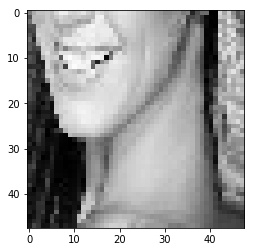

In [11]:
rgb = cv2.cvtColor(imges[0], cv2.COLOR_BGR2RGB)
plt.imshow(rgb)

# <font color="orange">Solving exercise using various machine learning approches</font> 

Once our images have been processed, we can split our dataset into train and test sets.

In [12]:
X = imgmgr.images
X = X.reshape(X.shape[0], np.prod(X.shape[1:]))
X_train, X_test, y_train, y_test = train_test_split(X, y)

### 1. Random Forest

Compare Gini vs Entropy as criterion. Entropy perform slightly better but error trend across number of estimators is similar, ie big drop at 20.

In [7]:
clf = sklearn.ensemble.RandomForestClassifier(n_estimators = 80, criterion="entropy", max_depth=5)
clf.fit(X_train, y_train)
y_pred_test = clf.predict(X_test)
y_pred_train = clf.predict(X_train)
print("TRAIN METRICS")
print(sklearn.metrics.classification_report(y_train, y_pred_train))
print("TEST METRICS")
print(sklearn.metrics.classification_report(y_test, y_pred_test))

TRAIN METRICS
              precision    recall  f1-score   support

           0       0.84      0.87      0.86      1899
           1       0.86      0.83      0.85      1851

    accuracy                           0.85      3750
   macro avg       0.85      0.85      0.85      3750
weighted avg       0.85      0.85      0.85      3750

TEST METRICS
              precision    recall  f1-score   support

           0       0.78      0.82      0.80       601
           1       0.83      0.79      0.81       649

    accuracy                           0.81      1250
   macro avg       0.81      0.81      0.81      1250
weighted avg       0.81      0.81      0.81      1250



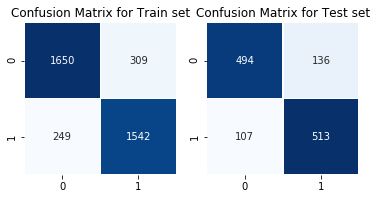

In [8]:
train_test_confusion_matrix(y_train, y_pred_train, y_test, y_pred_test)

No handles with labels found to put in legend.


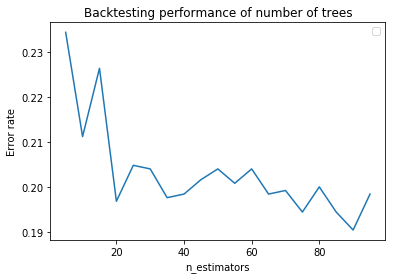

In [9]:
n_estimators=np.arange(5, 100, 5)

# Dictionary containing (<n_estimators>, <error rate>) pairs.
d = {}

for x in n_estimators:
    clf.set_params(n_estimators=x)
    clf.fit(X_train, y_train)
    error = 1 - clf.score(X_test, y_test)
    d[x] = error

plt.plot(d.keys(), d.values())
plt.xlabel("n_estimators")
plt.ylabel("Error rate")
plt.legend(loc="upper right")
plt.title('Backtesting performance of number of trees')
plt.show()

Now we perform some hyper-parameter tuning to see if other Random Forest arguments would have led to a significantly higher performance. The below dictionary will test 4 different sizes of n_estimators and max_depth. We have initialised this process as we initially observed that allowing a flexible "max_depth" variable would lead to overfitting. A table with score results is shown below.

In [10]:
param_grid = {'n_estimators': [20, 40, 60, 80],
              'max_depth':    [2, 7, 15, 20]}

In [11]:
grid_clf = sklearn.model_selection.GridSearchCV(clf, param_grid, cv=5)
grid_clf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(criterion='entropy', max_depth=5,
                                              n_estimators=95),
             param_grid={'max_depth': [2, 7, 15, 20],
                         'n_estimators': [20, 40, 60, 80]})

In [12]:
results_table = pd.DataFrame.from_dict(grid_clf.cv_results_).set_index("rank_test_score")
results_table

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score
rank_test_score,,,,,,,,,,,,,,
16,0.418305,0.043805,0.007739,0.000873,2,20,"{'max_depth': 2, 'n_estimators': 20}",0.724000,0.728000,0.693333,0.696000,0.716000,0.711467,0.014276
14,0.805020,0.050395,0.010007,0.000915,2,40,"{'max_depth': 2, 'n_estimators': 40}",0.732000,0.745333,0.720000,0.692000,0.694667,0.716800,0.020786
13,1.175837,0.028874,0.014560,0.002107,2,60,"{'max_depth': 2, 'n_estimators': 60}",0.728000,0.734667,0.729333,0.704000,0.697333,0.718667,0.015014
15,1.522662,0.016271,0.016747,0.001678,2,80,"{'max_depth': 2, 'n_estimators': 80}",0.740000,0.720000,0.700000,0.702667,0.700000,0.712533,0.015631
10,1.428902,0.024229,0.009212,0.001383,7,20,"{'max_depth': 7, 'n_estimators': 20}",0.798667,0.789333,0.785333,0.810667,0.805333,0.797867,0.009488
9,2.832254,0.033376,0.013935,0.001209,7,40,"{'max_depth': 7, 'n_estimators': 40}",0.798667,0.813333,0.796000,0.800000,0.788000,0.799200,0.008202
4,4.021663,0.349399,0.018042,0.006674,7,60,"{'max_depth': 7, 'n_estimators': 60}",0.820000,0.822667,0.810667,0.797333,0.797333,0.809600,0.010779
5,5.738464,0.912221,0.021966,0.003288,7,80,"{'max_depth': 7, 'n_estimators': 80}",0.802667,0.814667,0.805333,0.810667,0.800000,0.806667,0.005333
11,2.059352,0.035447,0.010950,0.001499,15,20,"{'max_depth': 15, 'n_estimators': 20}",0.801333,0.806667,0.786667,0.780000,0.781333,0.791200,0.010819


So, by running some cross-validation jobs and tuning the hyper-parameters, it is clear that our Random Forest classifier performs much better when a large depth of trees is allowed and "n_estimators" number is in the 60-80 range. Also, by choosing "entropy" rather than "gini" as the function to measure the quality of split, the scoring improves slightly.

### 2. Convolutional Neural Network

Resize and manipulate the train and tests sets in order to be in the right format for the CNN implementation, ie in tensor format.

In [13]:
X = X.reshape(5000,48,48,1)
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [14]:
# CNN Model
nb_filters = 16
nb_pool = 2
nb_conv = 3
nb_classes = 2 # binary classification problem

model = models.Sequential()

model.add(layers.Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu', input_shape=X.shape[1:]))
model.add(layers.Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(nb_classes))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 44, 16)        2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 22, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 22, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 7744)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                495680    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0

We can notice that model converges to val_accuracy=80% after 10 epochs. After noticing a high val_loss, I have then increased the Dropout amount to 50%.

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), verbose=True)

Epoch 1/10
118/118 [==============================] - 6s 55ms/step - loss: 2.4895 - accuracy: 0.5469 - val_loss: 0.6754 - val_accuracy: 0.5504
Epoch 2/10
118/118 [==============================] - 7s 60ms/step - loss: 0.6496 - accuracy: 0.6107 - val_loss: 0.5686 - val_accuracy: 0.7600
Epoch 3/10
118/118 [==============================] - 7s 63ms/step - loss: 0.5815 - accuracy: 0.6752 - val_loss: 0.5210 - val_accuracy: 0.7848
Epoch 4/10
118/118 [==============================] - 8s 67ms/step - loss: 0.5477 - accuracy: 0.7115 - val_loss: 0.5204 - val_accuracy: 0.7736
Epoch 5/10
118/118 [==============================] - 8s 72ms/step - loss: 0.5631 - accuracy: 0.7083 - val_loss: 0.4751 - val_accuracy: 0.7792
Epoch 6/10
118/118 [==============================] - 9s 72ms/step - loss: 0.4940 - accuracy: 0.7451 - val_loss: 0.4522 - val_accuracy: 0.7832
Epoch 7/10
118/118 [==============================] - 9s 76ms/step - loss: 0.4765 - accuracy: 0.7592 - val_loss: 0.4802 - val_accuracy: 0.7632

In [16]:
y_pred_test = np.argmax(model.predict(X_test), axis=1)
y_pred_train = np.argmax(model.predict(X_train), axis=1)
print("TRAIN METRICS")
print(sklearn.metrics.classification_report(y_train, y_pred_train))
print("TEST METRICS")
print(sklearn.metrics.classification_report(y_test, y_pred_test))

TRAIN METRICS
              precision    recall  f1-score   support

           0       0.81      0.94      0.87      1873
           1       0.93      0.78      0.85      1877

    accuracy                           0.86      3750
   macro avg       0.87      0.86      0.86      3750
weighted avg       0.87      0.86      0.86      3750

TEST METRICS
              precision    recall  f1-score   support

           0       0.74      0.88      0.81       627
           1       0.85      0.69      0.77       623

    accuracy                           0.79      1250
   macro avg       0.80      0.79      0.79      1250
weighted avg       0.80      0.79      0.79      1250



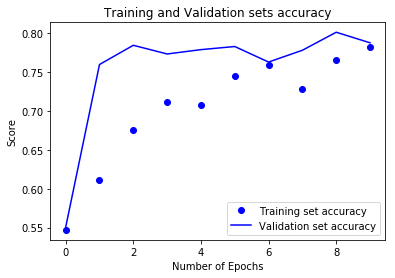

In [17]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training set accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation set accuracy')
plt.xlabel("Number of Epochs")
plt.ylabel("Score")
plt.title('Training and Validation sets accuracy')
plt.legend()
plt.show()

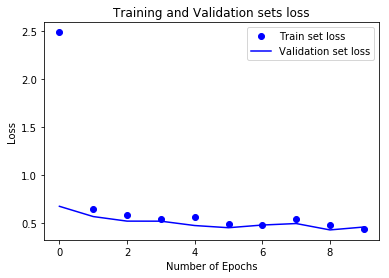

In [18]:
plt.figure()
plt.plot(epochs, loss, 'bo', label='Train set loss')
plt.plot(epochs, val_loss, 'b', label='Validation set loss')
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.title('Training and Validation sets loss')
plt.legend()
plt.show()